# Práctica 5: Cadenas de Markov

Autor: Yago Tobio Souto

---

**Librerías:**

In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

In [2]:
state = {
    0: 'Recibir invitación amigo', 
    1: 'Visitar página web principal', 
    2: 'Darse de alta con correo', 
    3: 'Descargarse el navegador', 
    4: 'Finalizar el proceso onboarding', 
    5: 'Usar navegador 6/7'
}

### Función para generar matrices de transición

Queremos que nuestra matriz de estados dependa de como se distribuyen los presupuestos de Marketing, este será el input de la función. 

Cambiar la distribución de presupuestos afectará a unos estados seleccionados, tal que si se incrementa una parte del funnel, las posibilidades que el usuario progrese a los siguientes estados aumente y vice-versa. 

In [16]:
def transition_matrix(sub_budgets):
    """
    Calculates a transition matrix based on modifications provided in sub_budgets.
    
    Parameters:
        sub_budgets (list or np.array): An array of 6 floats between 0 and 1, inclusive,
                                       that sum to exactly 1.
                                       
    Returns:
        np.array: A 6x6 transition matrix adjusted according to the sub_budgets.
    
    Raises:
        ValueError: If sub_budgets does not meet the required conditions.
    """
    # Validate input conditions
    if not isinstance(sub_budgets, (list, np.ndarray)):
        raise ValueError("sub_budgets must be a list or numpy array.")
    if len(sub_budgets) != 6:
        raise ValueError("sub_budgets must contain exactly 6 elements.")
    if not all(isinstance(x, (float, int)) for x in sub_budgets):
        raise ValueError("All elements in sub_budgets must be floats or integers.")
    if not all(0 <= x <= 1 for x in sub_budgets):
        raise ValueError("All elements in sub_budgets must be between 0 and 1.")
    if not np.isclose(sum(sub_budgets), 1):
        raise ValueError("The elements of sub_budgets must sum to 1.")
    
    # Initialize a base transition matrix
    base_matrix = np.array([
        # ? - See diagram as reference
        [0.2, 0.0, 0.8, 0.0, 0.0, 0.0],  # * Recibir invitación de un amigo
        [0.0, 0.2, 0.8, 0.0, 0.0, 0.0],  # * Visitar página web principal esta semana
        [0.2, 0.2, 0.0, 0.6, 0.0, 0.0],  # * Darse de alta con el correo
        [0.1, 0.1, 0.1, 0.0, 0.7, 0.0],  # * Descargar el navegador
        [0.2, 0.2, 0.0, 0.0, 0.0, 0.6],  # * Finalizar el proceso onboarding
        [0.1, 0.1, 0.0, 0.0, 0.1, 0.7]   # * Usar el navegador 6/7 días
    ])
    
    # Adjust the base matrix with sub_budgets and ensure no negative values
    adjustments = np.zeros((6, 6))

    # An example of how you might want to adjust the matrix
    # For each state, redistribute the budget to the transitions out of that state
    for i in range(6):
        # Here, we're simply adding the sub_budgets[i] to the diagonal
        # You will need to adjust this logic to fit your specific model.
        adjustments[i, i] = sub_budgets[i]

    # Apply the adjustments
    adjusted_matrix = base_matrix + adjustments

    for i in range(6): 
        adjusted_matrix[i] = np.clip(adjusted_matrix[i], 0, None)
        adjusted_matrix[i] /= np.sum(adjusted_matrix[i])

    return adjusted_matrix

### Visualización de un ejemplo: 

In [17]:
A = transition_matrix([0.1, 0.3, 0.1, 0.3, 0.1, 0.1])
print(A)

[[0.27272727 0.         0.72727273 0.         0.         0.        ]
 [0.         0.38461538 0.61538462 0.         0.         0.        ]
 [0.18181818 0.18181818 0.09090909 0.54545455 0.         0.        ]
 [0.07692308 0.07692308 0.07692308 0.23076923 0.53846154 0.        ]
 [0.18181818 0.18181818 0.         0.         0.09090909 0.54545455]
 [0.09090909 0.09090909 0.         0.         0.09090909 0.72727273]]


Verificación que todas las columnas sumen 1:

In [18]:
print(A.sum(axis=1))

[1. 1. 1. 1. 1. 1.]


---

### Función que genere distintas distribuciones de presupuesto:

Este caso sirve para aquellos casos en los que la empresa decida repartir distinto capital en las fases de la experiencia del usuario. 

In [19]:
def gen_budgets(length, n): 
    arrays = []
    for _ in range(n): 
        # * Generate random values for budget allocation 
        random_values = np.random.rand(length)
        # * Normalise
        normalized_array = random_values/random_values.sum()
        arrays.append(normalized_array)
    return arrays

In [20]:
length_example = 5
n_example = 10**3 # ? - Número de iteraciones 
arrays_distribution = gen_budgets(length_example, n_example)

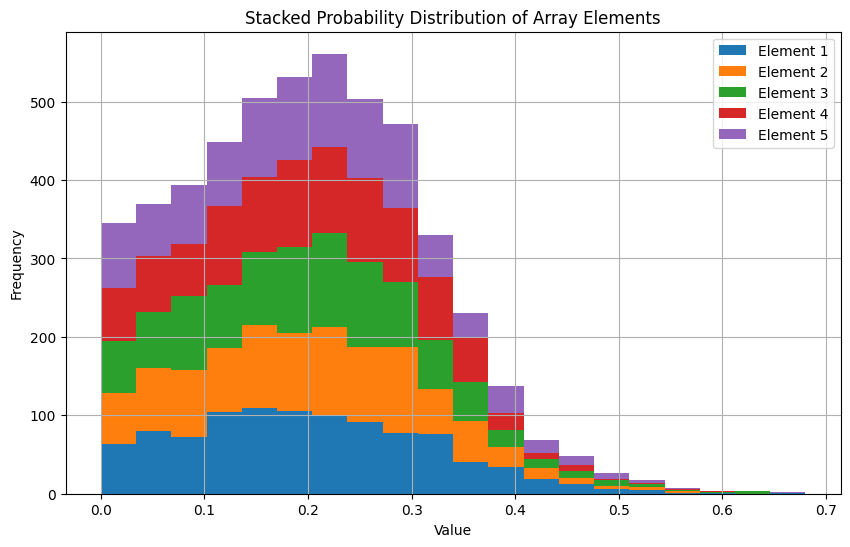

In [21]:
 # * Plot distributions
# Plotting
plt.figure(figsize=(10, 6))
data_to_plot = [np.array([arr[i] for arr in arrays_distribution]) for i in range(length_example)]
plt.hist(data_to_plot, bins=20, stacked=True, label=[f'Element {i+1}' for i in range(length_example)])

plt.title('Stacked Probability Distribution of Array Elements')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

Podemos observar que no hay una distribución ni simetrica ni homogenea, pero si que se cubre un gran rango de valores posibles para cada estado

### Metodología para obtener el mejor presupuesto, con el fin de optimizar nuestra base de usuarios

In [22]:
steps = 10**3
sub_budgets = gen_budgets(6, steps)

matrixes = []
yields = []

for budget in sub_budgets: 
    A = transition_matrix(budget)
    A_n = A 
    for s in range(steps):
        A_n = np.matmul(A_n, A)
    matrixes.append(A_n)
    yields.append(A_n[5,5]) # ? - Obtener la probabilidad que garantiza el cliente

In [23]:
# * De las matrices identificar aquella combinación de budget que otorge un mayor numero de clientes: 
max_yield_index = np.argmax(yields)
max_yield = yields[max_yield_index]
max_matrix = matrixes = matrixes[max_yield_index]
max_sub_budget = sub_budgets[max_yield_index]

print(f"Maxima tasa de clientes fidelizados: {max_yield}")
print(f"\nMatriz de transición correspondiente:\n{max_matrix}")
print(f"\nCombinación de presupuesto que generó esto:\n {max_sub_budget}")

Maxima tasa de clientes fidelizados: 0.3185689662265763

Matriz de transición correspondiente:
[[0.14390095 0.11663703 0.19751903 0.1166848  0.10668922 0.31856897]
 [0.14390095 0.11663703 0.19751903 0.1166848  0.10668922 0.31856897]
 [0.14390095 0.11663703 0.19751903 0.1166848  0.10668922 0.31856897]
 [0.14390095 0.11663703 0.19751903 0.1166848  0.10668922 0.31856897]
 [0.14390095 0.11663703 0.19751903 0.1166848  0.10668922 0.31856897]
 [0.14390095 0.11663703 0.19751903 0.1166848  0.10668922 0.31856897]]

Combinación de presupuesto que generó esto:
 [0.27754349 0.03549617 0.03021733 0.01433853 0.05993965 0.58246483]
